## Modeling

### Imports

In [1]:
# imports
import pandas as pd
import numpy as np
import sqlite3

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score,
                                     StratifiedKFold,
                                     GridSearchCV)

from sklearn.linear_model import (LogisticRegression, 
                                  LassoCV, 
                                  Lasso)

from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from nltk.stem.porter import *
from  nltk.stem import PorterStemmer

from sklearn.metrics import (precision_score,
                             f1_score,
                             recall_score,
                             accuracy_score,
                             confusion_matrix,
                             ConfusionMatrixDisplay, 
                             classification_report,
                             roc_curve,
                             auc)

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from matplotlib import pyplot as plt
np.random.seed(73)
tf.random.set_seed(73)

### Functions

In [2]:
def score(model, name, X, y):
    cv = StratifiedKFold(n_splits=10,
                         random_state=73,
                         shuffle=True)
    s = cross_val_score(model, X, y, cv=cv,
                        n_jobs=-1)
    print('{} Score: {:.2f} +- {:.3f}'.format(name, 
                                              s.mean(), 
                                              2 * s.std()))

In [3]:
# confusion matrix
def con_matrix(model, X, y, title):
    conmat = np.array(confusion_matrix(y, 
                                       model.predict(X), 
                                       labels=[0, 1]))

    print(classification_report(y,
                        model.predict(X), 
                        zero_division=True,
                        target_names=['Not Useful', 'Useful']))

    matrix_display = ConfusionMatrixDisplay(confusion_matrix=conmat, 
                            display_labels=['Not useful','useful'])
    matrix_display.plot()

    figure = plt.gcf()
    plt.title(title)
    figure.set_size_inches(8, 8)

In [4]:

def roc_plot(model, X, y, title):
    y_proba = model.predict_proba(X)
    fpr, tpr, _ = roc_curve(y, y_proba[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)


    plt.figure(figsize=[8,8])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC for Useful Reviews ({})'.format(title), fontsize=16)
    plt.legend(loc="lower right")
    ;

## Baseline

In [5]:
# load data
db_con = sqlite3.connect('../data/yelp.db.sqlite')

In [6]:
# create dataframe
reviews = pd.DataFrame(pd.read_sql('select * from \
reviews_cleaned;',
           con=db_con))

In [7]:
reviews.target.value_counts(normalize=True)

0    0.555053
1    0.444947
Name: target, dtype: float64

The baseline of the target is 0.56, for reviews with zero useful votes.

### Pre-processing

The following section applies stemming to the corpus.  The data is then vectorized using TD-IDF.  From there, lasso is used to reduce the number of vectorized columns.  The final result of that is then concatenated with the original dataframe to produce the final modeling columns.

In [8]:
# apply stemmer
stemmer = PorterStemmer()
reviews['text'] = reviews['text'].apply(lambda x: stemmer.stem(x))

In [9]:
## instantiate vectorizer
tvec = TfidfVectorizer(stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 200,
                       max_df = .60,
                       norm = 'l2'
                      )
tvec.fit(reviews.text)

TfidfVectorizer(max_df=0.6, max_features=200, stop_words='english',
                strip_accents='ascii')

In [10]:
# create vectorized dataframe
reviews_tvec = pd.DataFrame(tvec.transform(reviews.text).todense(),
                  columns = tvec.get_feature_names())

In [11]:
# add target to tvec data
reviews_tvec['target'] = reviews.target

In [12]:
# instsantiate X and y for tvec data
X_tvec = reviews_tvec.drop(['target'], axis = 1)
y_tvec = reviews_tvec.target

***Note*** we are using lasso to reduce collumns

In [13]:
# instantiate LassoCV model
lasso_cv = LassoCV(cv=5, max_iter=10000, tol=0.001)\
.fit(X_tvec, y_tvec)

In [14]:
# fit model and generate columns for modeling
new_lasso = Lasso(alpha=lasso_cv.alpha_)

new_lasso.fit(X_tvec, y_tvec)

final_col_for_modeling_best_alpha = [col for col, \
        coef in zip(X_tvec.columns, new_lasso.coef_) if coef]

In [15]:
# generate new dataframe using final columns
reviews_tvec = reviews_tvec[final_col_for_modeling_best_alpha]

In [16]:
# concat vectorized and reviews dataframes
reviews_final = pd.concat([reviews,reviews_tvec],axis=1)

We then instantiate X and y, do a train test split, and standard scale in preparation for modeling.

In [17]:
# instantiate X and y
X = reviews_final.drop(['review_id', 'user_id', 'business_id', 
                        'date','text','useful','target'], axis=1)
y = reviews_final.target

In [18]:
# set up train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        test_size=0.2, random_state=73)

In [19]:
# standard scale the data
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)

X_test_ss = ss.transform(X_test)

### Logistic Regression Model

In [20]:
# set up gridsearch params
log_params = {'C': [10.0, 100.0]}

# Instantiate GridSearchCV object.
log_grid = GridSearchCV(LogisticRegression(),
                              log_params,
                              cv=5,
                              verbose=0)

In [21]:
# run gridsearch
log_grid.fit(X_train_ss, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [10.0, 100.0]})

In [22]:
print(str(log_grid.best_score_) + ' best score')
print(str(log_grid.best_estimator_) + ' best model')
print(str(log_grid.best_params_) + ' best params')

0.6228724655016509 best score
LogisticRegression(C=100.0) best model
{'C': 100.0} best params


In [20]:
lr = LogisticRegression(solver='liblinear',
                       C=10,
                       penalty='l2',
                       random_state=73
                       )

lr.fit(X_train_ss, y_train)

LogisticRegression(C=10, random_state=73, solver='liblinear')

In [21]:
lr_imp = {feature: importance for feature, importance in zip(X.columns, 
                                lr.coef_[0])}

- An increase in one standard deviation **num_chars** is associated with 1.58 increase in the odds of a useful post.

- An increase in one standard deviation **need** is associated with 1.07 increase in the odds of a useful post.

- An increase in one standard deviation **new** is associated with 1.06 increase in the odds of a useful post.

- An increase in one standard deviation **store** is associated with 1.06 increase in the odds of a useful post.

- An increase in one standard deviation **shop** is associated with 1.06 increase in the odds of a useful post.

- An increase in one standard deviation **place** is associated with 1.06 increase in the odds of a useful post.

- An increase in one standard deviation **review** is associated with 1.06 increase in the odds of a useful post.

- An increase in one standard deviation **way** is associated with 1.05 increase in the odds of a useful post.

- An increase in one standard deviation **decided** is associated with 1.05 increase in the odds of a useful post.

- An increase in one standard deviation **youre** is associated with 1.05 increase in the odds of a useful post.

- An increase in one standard deviation **num_words** is associated with 0.92 decrease in the odds of a useful post.

- An increase in one standard deviation **atmosphere** is associated with 0.94 decrease in the odds of a useful post.

- An increase in one standard deviation **food** is associated with 0.95 decrease in the odds of a useful post.

- An increase in one standard deviation **server** is associated with 0.96 decrease in the odds of a useful post.

- An increase in one standard deviation **table** is associated with 0.96 decrease in the odds of a useful post.



### Logistic regression Metrics

In [22]:
# score the X_train
score(lr, 'Logistic regression', X_train_ss, y_train)

Logistic regression Score: 0.62 +- 0.024


In [23]:
# score the X_test
score(lr, 'Logistic regression', X_test_ss, y_test)

Logistic regression Score: 0.62 +- 0.036


              precision    recall  f1-score   support

  Not Useful       0.64      0.77      0.70      2327
      Useful       0.61      0.45      0.52      1831

    accuracy                           0.63      4158
   macro avg       0.63      0.61      0.61      4158
weighted avg       0.63      0.63      0.62      4158



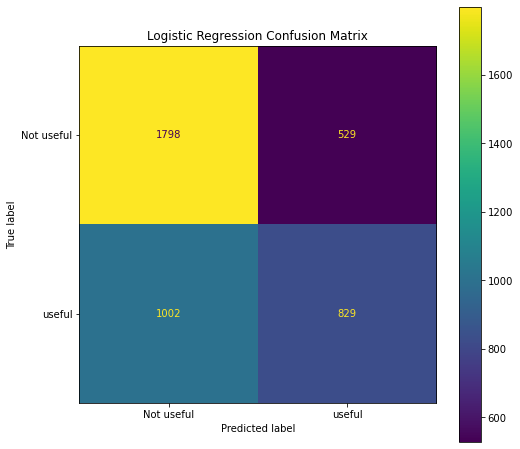

In [24]:
con_matrix(lr, X_test_ss, y_test, 'Logistic Regression Confusion Matrix')

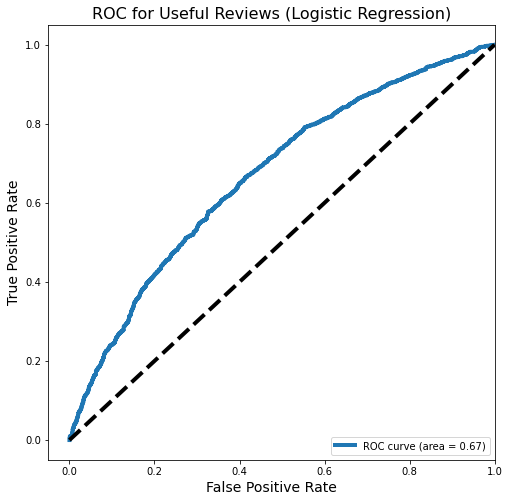

In [25]:
roc_plot(lr, X_test_ss, y_test, 'Logistic Regression')

The logistic regression model had an r-squared score of 0.62 +/- 0.036 for training data, while the test data scored slightly better with 0.62 +/- 0.038.  For precision, out of all the reviews that the model predicted would be useful, only 61% actually were.  For recall, out of all the reviews that actually were useful, the model predicted this outcome correctly for 61% of those reviews.  For the F-1 score, this value isn’t very close to 1, it tells us that the model does a poor job of predicting whether or not reviews will be useful.  The ROC score is below the acceptable range of 0.7+.  The model is better a predicting true and false negatives. The model performs above the baseline of 0.56.

### Random Forest Model

In [26]:
# set up gridsearch params
forest_params = {'n_estimators': [10, 50, 100, 200],
                    'min_samples_leaf': [1, 5, 10]
                }

# Instantiate GridSearchCV object.
forest_grid = GridSearchCV(RandomForestClassifier(),
                              forest_params,
                              cv=5,
                              verbose=0)

In [27]:
# run gridsearch
forest_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [10, 50, 100, 200]})

In [31]:
print(str(forest_grid.best_score_) + ' best score')
print(str(forest_grid.best_params_) + ' best params')

0.6324930536992023 best score
{'min_samples_leaf': 10, 'n_estimators': 200} best params


In [31]:
# instantiate and fit
rf = RandomForestClassifier(n_jobs=-1,
                            random_state=73,
                            n_estimators=50,
                            min_samples_leaf=10,
                            warm_start=True)
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=10, n_estimators=50, n_jobs=-1,
                       random_state=73, warm_start=True)

In [105]:
rf_import = {feature: importance for feature, importance in zip(X.columns, 
                                    rf.feature_importances_)}

The top 10 features of importance are:
- num_words: 0.116852603839513
- num_chars: 0.116775248360491
- great: 0.0219457440853888
- food: 0.021819203442455
- like: 0.0185179958853776
- just:	0.0181470784017227
- good:	0.0180133322368666
- place: 0.0175578033980874
- service:	0.0164868162826096
- time:	0.0129833720952967

The bottom 5 features of importance are:
- rice:	0.0008681280395603
- house: 0.000835254650819013
- soup:	0.000777326018836878
- sushi: 0.000769274024751508
- inside: 0.000595344306760098

### Random Forest Metrics

In [33]:
# score the X_train
score(rf, 'Random Forest', X_train, y_train)

Random Forest Score: 0.63 +- 0.018


In [34]:
# score the X_test
score(rf, 'Random Forest', X_test, y_test)

Random Forest Score: 0.64 +- 0.036


              precision    recall  f1-score   support

  Not Useful       0.66      0.71      0.69      2327
      Useful       0.60      0.54      0.57      1831

    accuracy                           0.64      4158
   macro avg       0.63      0.63      0.63      4158
weighted avg       0.63      0.64      0.63      4158



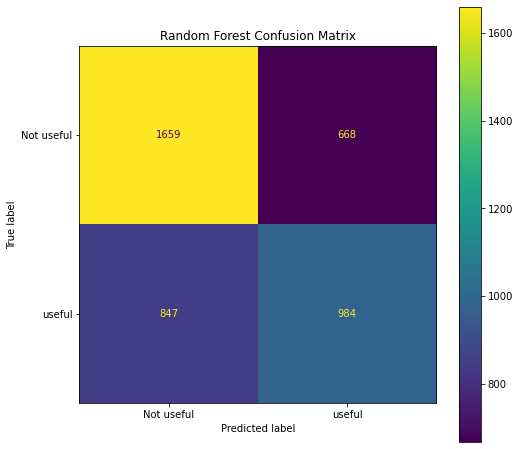

In [35]:
con_matrix(rf, X_test, y_test, 'Random Forest Confusion Matrix')

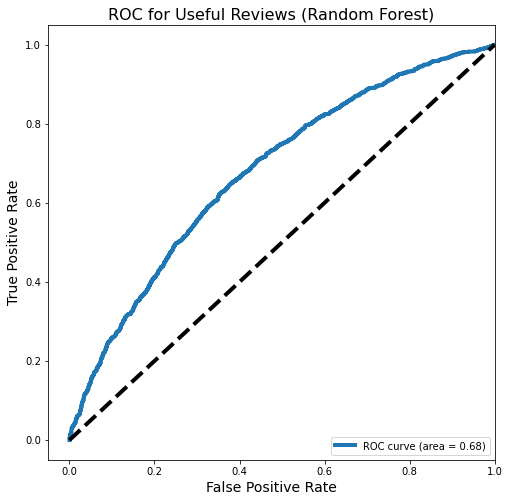

In [36]:
roc_plot(rf, X_test, y_test, 'Random Forest')

The random forest model had an r-squared score of 0.63 +/- 0.018 for training data, while the test data scored slightly better with 0.64 +/- 0.036.  For precision, out of all the reviews that the model predicted would be useful, only 60% actually were.  For recall, out of all the reviews that actually were useful, the model predicted this outcome correctly for 54% of those reviews.  For the F-1 score, this value isn’t very close to 1, it tells us that the model does a poor job of predicting whether or not reviews will be useful.  The ROC score is slightly below the acceptable range of 0.7+.  The model is better at predicting true negatives over true positives. The model performs slightly worse than the regression model for predicting true negatives, and slightly better than the regression model for predicting true positives. The model performs above the baseline of 0.56.


### SVM

In [54]:
# set up gridsearch params
svm_params = {"C":[1e-4, 1e-3, 1e-2],"max_iter":[900, 1000]}

# Instantiate GridSearchCV object.
svm_grid = GridSearchCV(LinearSVC(),
                              svm_params,
                              cv=5,
                              verbose=0)

In [55]:
# run gridsearch
svm_grid.fit(X_train_ss, y_train)

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.0001, 0.001, 0.01], 'max_iter': [900, 1000]})

In [57]:
print(str(svm_grid.best_score_) + ' best score')
print(str(svm_grid.best_params_) + ' best params')

0.6241950867200898 best score
{'C': 0.0001, 'max_iter': 900} best params


In [37]:
svm = LinearSVC(random_state=73, C=0.0001, 
               max_iter=900, class_weight='balanced'
               )

svm.fit(X_train_ss, y_train)

LinearSVC(C=0.0001, class_weight='balanced', max_iter=900, random_state=73)

In [112]:
svm_imp = {feature: importance for feature, importance in zip(X.columns, 
                                svm.coef_[0])}

The top 10 features of importance are:
- num_chars: 0.0731074709023004
- num_words: 0.0706336909297431
- need: 0.0243700158090742
- store: 0.0233206964159656
- new: 0.0226733283983515
- shop:	0.0220623101765558
- review: 0.0209544714195946
- place: 0.0201454488498059
- way: 0.0195850505076461
- decided: 0.0186947795954821

The bottom 5 features of importance are:
- table: -0.0116831907590799
- server: -0.0144903206662121
- wonderful: -0.0147141976595887
- food: -0.0200203133655886
- atmosphere: -0.0213550597853493

### SVM Metrics

In [39]:
# score the X_train
score(svm, 'SVM', X_train_ss, y_train)

SVM Score: 0.62 +- 0.017


In [40]:
# score the X_test
score(svm, 'SVM', X_test_ss, y_test)

SVM Score: 0.62 +- 0.043


              precision    recall  f1-score   support

  Not Useful       0.67      0.67      0.67      2327
      Useful       0.58      0.58      0.58      1831

    accuracy                           0.63      4158
   macro avg       0.62      0.62      0.62      4158
weighted avg       0.63      0.63      0.63      4158



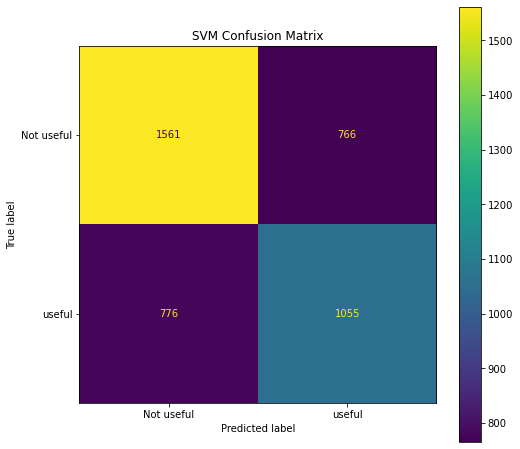

In [41]:
# generate confusion matrix
con_matrix(svm, X_test_ss, y_test, 'SVM Confusion Matrix')

In [42]:
# convert to calibrated classifier to access proba
clf = CalibratedClassifierCV(svm)
clf.fit(X_train_ss, y_train)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.0001,
                                                class_weight='balanced',
                                                max_iter=900, random_state=73))

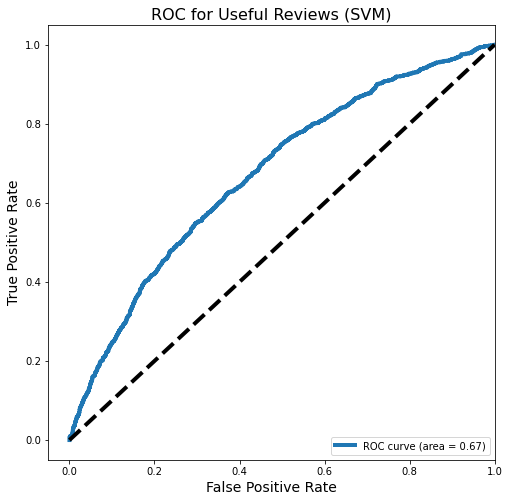

In [43]:
# plot roc curve
roc_plot(clf, X_test_ss, y_test, 'SVM')

The logistic regression model had an r-squared score of 0.62 +/- 0.017 for training data, while the test data scored slightly better with 0.62 +/- 0.043.  For precision, out of all the reviews that the model predicted would be useful, only 58% actually were.  For recall, out of all the reviews that actually were useful, the model predicted this outcome correctly for 58% of those reviews.  For the F-1 score, this value isn’t very close to 1, it tells us that the model does a poor job of predicting whether or not reviews will be useful.  The ROC curve is below the acceptable range of 0.7+.  The model performed the best in predicting true positives, but didn't perform as well as the logistic regression or the random forest for predicting true positives.  The model performs above the baseline of 0.56.

### Neural Network

In [97]:
# initialize the model
model = Sequential() 

model.add(layers.Dense(1024, 
        input_shape=(X.shape[1],), 
        kernel_regularizer=l2(0.001),
        activation='relu')) 

model.add(layers.Dense(512, 
        kernel_regularizer=l2(0.001),
        activation='relu')) 

model.add(layers.Dense(128, 
        kernel_regularizer=l2(0.001),
        activation='relu')) 

model.add(layers.Dense(32, 
        kernel_regularizer=l2(0.001),
        activation='relu'))

model.add(layers.Dense(1, 
        kernel_regularizer=l2(0.001),
        activation='sigmoid')) 


model.compile(optimizer='adam', 
                            loss='binary_crossentropy', metrics=['accuracy'])

In [101]:
# fit the mpdel
history = model.fit(X_train, y_train, 
    validation_data = (X_test, y_test), 
    batch_size = 100, epochs = 10)



Epoch 1/10
167/167 [==============================] - 5s 29ms/step - loss: 0.8254 - accuracy: 0.6157 - val_loss: 0.8085 - val_accuracy: 0.6376
Epoch 2/10
167/167 [==============================] - 5s 30ms/step - loss: 0.8151 - accuracy: 0.6136 - val_loss: 0.7975 - val_accuracy: 0.6342
Epoch 3/10
167/167 [==============================] - 5s 31ms/step - loss: 0.8075 - accuracy: 0.6111 - val_loss: 0.7909 - val_accuracy: 0.6409
Epoch 4/10
167/167 [==============================] - 5s 31ms/step - loss: 0.7942 - accuracy: 0.6176 - val_loss: 0.7804 - val_accuracy: 0.6412
Epoch 5/10
167/167 [==============================] - 6s 34ms/step - loss: 0.7822 - accuracy: 0.6191 - val_loss: 0.7723 - val_accuracy: 0.6376
Epoch 6/10
167/167 [==============================] - 6s 33ms/step - loss: 0.7748 - accuracy: 0.6207 - val_loss: 0.7619 - val_accuracy: 0.6397
Epoch 7/10
167/167 [==============================] - 6s 38ms/step - loss: 0.7658 - accuracy: 0.6220 - val_loss: 0.7523 - val_accuracy: 0.6364

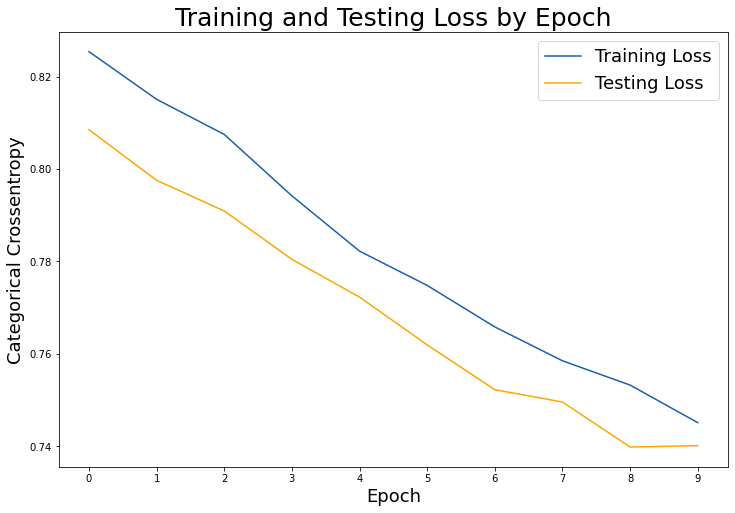

In [102]:

# Check out our train loss and test loss over epochs
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Set figure size
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(np.arange(10), np.arange(10))

plt.legend(fontsize = 18);

In [103]:

# Evaluate model on test data
score = model.evaluate(X_test,
                       y_test,
                       verbose=1)

labels = model.metrics_names

# Show model performance
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

130/130 [==============================] - 1s 8ms/step - loss: 0.7401 - accuracy: 0.6323
loss: 0.7401441335678101
accuracy: 0.6322751045227051


The neural network was set up with 3 hidden layers and run for 10 epochs.  It generally scores similar results to the SVM, logistic regression, and random forest (in the ballpark of around 0.63 r-squared).  Loss seems to decrease to around 0.75-0.85.

### Conclusion

In determining whether a yelp review is useful or not, over 20,000 features were analyzed.  These features were passed through TF-IDF to vectorize, which generated 200 vectors for analysis.  These vectors were subset with lasso, then fed into four models: logistic regression, random forest, SVM, and a neural network.  

The models all seemed to perform comparatively when it came to producing r-squared scores.  The neural network and random forest models both performed slightly better with r-squared scores of and 0.63 and 0.64.  All models beat the baseline of 0.56.  

When predicting the true negatives (successfully predicting reviews that had no useful votes), the logistic regression model performed better than SVM and random forest. However, when it came to predicting true positives (successfully predicting reviews that had useful votes), SVM had the best results.  Random forest had the lowest score for predicting true positives.  

The logistic regression model had the best precision for predicting useful reviews.  In other words,  this model had the best ability to determine what measure of “useful” identifications were actually correctly identified as useful.  While SVM, on the other hand, had the worst precision. SVM did, however, have the best recall/sensitivity rate, which is the models ability to find all relevant cases of usefulness.  Finally, SVM also had the best f1-score.  

When it comes to analyzing the word vectors themselves, there is extensive overlap between the highest logistic regression coefficients, and the SVM feature importances.  The following word tokens are shared between the two models: ‘shop', 'new', 'need', 'way', ‘num_chars’, 'decided', 'store', 'review', ‘place’.  While ‘place’ and ‘num_chars’ is shared among logistic regression, random forest, and SVM.  

As far as themes, there seem to be at least a couple of themes in the word tokens with the highest values (either in coefficients, or feature importances).  The first theme is location.  Words such as ‘place’, ‘store’, and ‘shop’, for example, are all examples of location-based word tokens.  The second theme that stands out is compliments.  Words such as ‘great’, ‘good’, and (possibly, depending on context) ‘like’.  One interesting note, is that the compliments theme comes exclusively from the random forest model.  There doesn’t seem to be features with high values that are compliments in either the logistic regression model or the SVM.  There is only one location-based word token for the random forest model.  There **are** a couple of temporal word tokens (‘new’, and ‘time’) that appear in the logistic regression and random forest model respectively. Finally, tokens such as ‘service’ and ‘food’ are interesting too, because they’re representative of transaction.  

Finally, I would say that the best performing model was the SVM model.  It had the most consistent results with precision/recall/f1-score.  It also had a high number of true positive **and** true negative predictions, and only had a 1-2% drop in r-squared score compared to the neural network and the random forest model.